In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('AirQuality.csv',sep=";",parse_dates=[['Date', 'Time']],decimal=',',na_values=-200,na_filter=True)
data.drop(["Unnamed: 15","Unnamed: 16"],axis = 1,inplace = True)
data.head()

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004 18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004 19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004 20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004 21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004 22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date_Time      9471 non-null   object 
 1   CO(GT)         7674 non-null   float64
 2   PT08.S1(CO)    8991 non-null   float64
 3   NMHC(GT)       914 non-null    float64
 4   C6H6(GT)       8991 non-null   float64
 5   PT08.S2(NMHC)  8991 non-null   float64
 6   NOx(GT)        7718 non-null   float64
 7   PT08.S3(NOx)   8991 non-null   float64
 8   NO2(GT)        7715 non-null   float64
 9   PT08.S4(NO2)   8991 non-null   float64
 10  PT08.S5(O3)    8991 non-null   float64
 11  T              8991 non-null   float64
 12  RH             8991 non-null   float64
 13  AH             8991 non-null   float64
dtypes: float64(13), object(1)
memory usage: 1.0+ MB


In [4]:
data.tail()

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9466,nan nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,nan nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,nan nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,nan nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9470,nan nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.fillna(method='ffill',inplace=True)
data.drop_duplicates(inplace=True)
data.shape

(9358, 14)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9358 entries, 0 to 9357
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date_Time      9358 non-null   object 
 1   CO(GT)         9358 non-null   float64
 2   PT08.S1(CO)    9358 non-null   float64
 3   NMHC(GT)       9358 non-null   float64
 4   C6H6(GT)       9358 non-null   float64
 5   PT08.S2(NMHC)  9358 non-null   float64
 6   NOx(GT)        9358 non-null   float64
 7   PT08.S3(NOx)   9358 non-null   float64
 8   NO2(GT)        9358 non-null   float64
 9   PT08.S4(NO2)   9358 non-null   float64
 10  PT08.S5(O3)    9358 non-null   float64
 11  T              9358 non-null   float64
 12  RH             9358 non-null   float64
 13  AH             9358 non-null   float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [7]:
data.tail()

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9353,04/04/2005 11.00.00,2.4,1163.0,275.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005 12.00.00,2.4,1142.0,275.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005 13.00.00,2.1,1003.0,275.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139
9356,04/04/2005 14.00.00,2.2,1071.0,275.0,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028
9357,nan nan,2.2,1071.0,275.0,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028


In [8]:
data.drop(9357,inplace = True)
data.tail()

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,04/04/2005 10.00.00,3.1,1314.0,275.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005 11.00.00,2.4,1163.0,275.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005 12.00.00,2.4,1142.0,275.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005 13.00.00,2.1,1003.0,275.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139
9356,04/04/2005 14.00.00,2.2,1071.0,275.0,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028


In [9]:
data['Date_Time'] = pd.to_datetime(data['Date_Time'],format="%d/%m/%Y %H.%M.%S")

In [398]:
d_r = data.set_index('Date_Time')
# d_r = data

In [384]:
scaler_co = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
d_r['CO(GT)'] = scaler_co.fit_transform(d_r['CO(GT)'].to_numpy().reshape(-1,1))

In [386]:
scaler_t = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
d_r['T'] = scaler_t.fit_transform(d_r['T'].to_numpy().reshape(-1,1))

In [399]:
d_r.tail()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2005-04-04 10:00:00,3.1,1314.0,275.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163.0,275.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142.0,275.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
2005-04-04 13:00:00,2.1,1003.0,275.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139
2005-04-04 14:00:00,2.2,1071.0,275.0,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7b9f3cf50>,
      dtype=object)

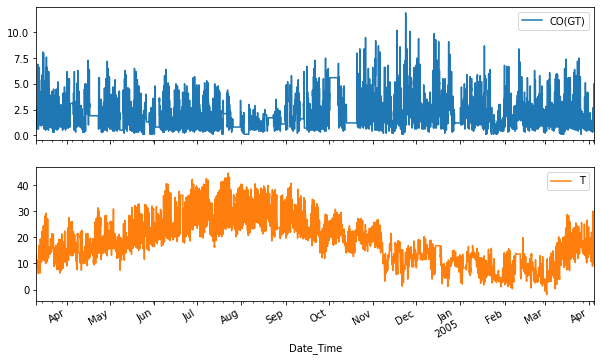

In [400]:
d_r[['CO(GT)','T']].plot(subplots=True, figsize=(10,6))

In [64]:
print(f'min : {data["Date_Time"].min()} max : {data["Date_Time"].max()}')
print(f'difference of min max : {data["Date_Time"].iloc[-1] - data["Date_Time"].iloc[0]}')#pd.to_datetime(data["Date_Time"].iloc[-1]) - pd.to_datetime(data["Date_Time"].iloc[0])}')

min : 2004-03-10 18:00:00 max : 2005-04-04 14:00:00
difference of min max : 389 days 20:00:00


```python
macro_data = d_r
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(10,13),squeeze=True)
for i, ax in enumerate(axes.flatten()):
#     if i == 0 or i == 11:
#     if i == 0 :
#         pass
    data = macro_data[macro_data.columns[i]]
#         print(data)
#     ax.plot(macro_data['Date_Time'],data, color='lightblue')#, linewidth=1)
    ax.plot(data,color='red')
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
```

In [ ]:
ad_fuller_result_1 = adfuller(macro_data['CO(GT)'].diff()[1:])

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['T'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

In [ ]:
print('CO(GT) causes T?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_data[['T', 'CO(GT)']], 4)

print('\nT causes CO(GT)?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_data[['CO(GT)', 'T']], 4)

## ToDo
#### preprocessing

* chose edge padding

~~+ wavelet transform~~

~~+ discrete cosine transform~~

#### training length
temporary
+ past 4 days [96 input points 24 output points]
+ past 3 days [72 input points 24 output points] 
+ past 2 days [48 input points 24 output points]
+ past 1 days [24 input points 24 output points]


#### modeling 
+ SARIMA
+ Bidirectional LSTM's

~~+ XGBoost~~

Remember : should implement online leanring technique

Note : Yes, the participants need to use temperature data independently to evaluate their algorithm. Dont use temperature data to forecast CO and vice versa.

Initial Training Data Period: 7 days from 11/03/2004 00.00.00 to 17/03/2004 23.00.00 ✅ 

Testing Data Period: 7 days from 18/03/2004 00.00.00 to 24/03/2004 23.00.00 ✅ 

Each day of the training and test data period have 24 data points starting from 00.00.00 to 23.00.00. ✅

Understanding : 
outof all the samples take only those 2 sets..

according to it each day is having 24 points (Check it) ✅ 

follow up the procedure given ..

Question: so how many samples in a day should be predicted i.e. output should be a float or list ??

can be found out in eda..

### Re-Training on Test Data is not necessary.

In [65]:
data[data['Date_Time'] == pd.to_datetime('11/03/2004 00.00.0',format="%d/%m/%Y %H.%M.%S")]

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
6,2004-03-11,1.2,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603


In [66]:
data.iloc[6:6+7]

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
6,2004-03-11 00:00:00,1.2,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603
7,2004-03-11 01:00:00,1.0,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702
8,2004-03-11 02:00:00,0.9,1094.0,24.0,2.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648
9,2004-03-11 03:00:00,0.6,1010.0,19.0,1.7,561.0,45.0,1705.0,60.0,1235.0,501.0,10.3,60.2,0.7517
10,2004-03-11 04:00:00,0.6,1011.0,14.0,1.3,527.0,21.0,1818.0,34.0,1197.0,445.0,10.1,60.5,0.7465
11,2004-03-11 05:00:00,0.7,1066.0,8.0,1.1,512.0,16.0,1918.0,28.0,1182.0,422.0,11.0,56.2,0.7366
12,2004-03-11 06:00:00,0.7,1052.0,16.0,1.6,553.0,34.0,1738.0,48.0,1221.0,472.0,10.5,58.1,0.7353


In [67]:
d_r.iloc[6:6+168]

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-11 00:00:00,0.093220,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,0.283871,56.8,0.7603
2004-03-11 01:00:00,0.076271,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,0.270968,60.0,0.7702
2004-03-11 02:00:00,0.067797,1094.0,24.0,2.3,609.0,45.0,1579.0,60.0,1276.0,620.0,0.270968,59.7,0.7648
2004-03-11 03:00:00,0.042373,1010.0,19.0,1.7,561.0,45.0,1705.0,60.0,1235.0,501.0,0.262366,60.2,0.7517
2004-03-11 04:00:00,0.042373,1011.0,14.0,1.3,527.0,21.0,1818.0,34.0,1197.0,445.0,0.258065,60.5,0.7465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-03-17 19:00:00,0.635593,1973.0,577.0,38.4,1737.0,411.0,617.0,194.0,2414.0,2306.0,0.537634,26.5,0.7403
2004-03-17 20:00:00,0.559322,1975.0,523.0,35.1,1667.0,347.0,597.0,182.0,2416.0,2359.0,0.481720,38.2,0.9133
2004-03-17 21:00:00,0.474576,1795.0,472.0,27.2,1485.0,336.0,653.0,180.0,2174.0,2050.0,0.451613,42.6,0.9294


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7ba1362d0>,
      dtype=object)

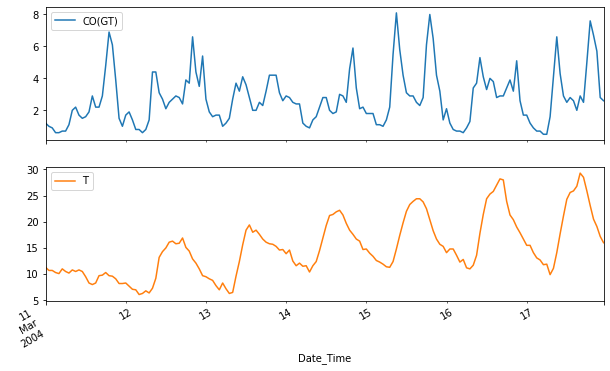

In [401]:
d_r[['CO(GT)','T']].iloc[6:6+168].plot(subplots=True, figsize=(10,6))

In [69]:
d_r[['CO(GT)','T']].iloc[6+168:6+2*168]

,CO(GT),T
Date_Time,,
2004-03-18 00:00:00,0.186441,0.359140
2004-03-18 01:00:00,0.110169,0.348387
2004-03-18 02:00:00,0.076271,0.359140
2004-03-18 03:00:00,0.050847,0.339785
2004-03-18 04:00:00,0.050847,0.290323
...,...,...
2004-03-24 19:00:00,0.372881,0.270968
2004-03-24 20:00:00,0.288136,0.273118
2004-03-24 21:00:00,0.211864,0.262366


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe877cd2ad0>,
      dtype=object)

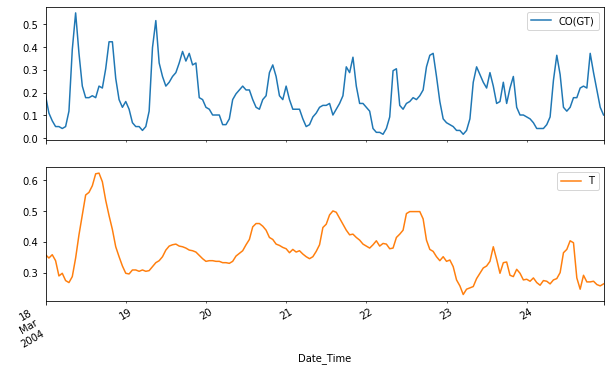

In [70]:
d_r[['CO(GT)','T']].iloc[6+168:6+2*168].plot(subplots=True, figsize=(10,6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8760b0390>,
      dtype=object)

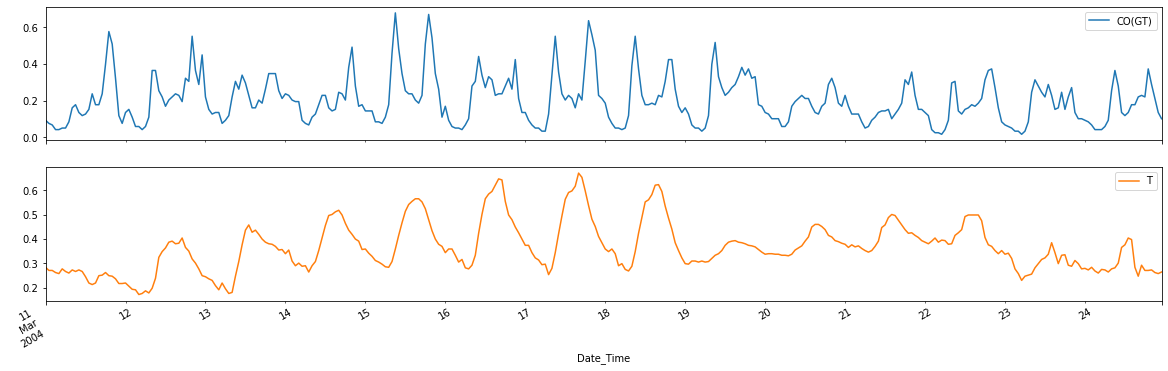

In [71]:
d_r[['CO(GT)','T']].iloc[6:6+2*168].plot(subplots=True, figsize=(20,6))

In [402]:
train_data = d_r[['CO(GT)','T']].iloc[6:6+168]
test_data = d_r[['CO(GT)','T']].iloc[6+168:6+2*168]

In [403]:
test_np = train_data['T'].to_numpy()

In [ ]:
for i in range(2*150):
    try : 
        print(f'train : {test_np[i:i+72]} test : {test_np[i+72:i+72+24]} i : {i} len of test : {len(test_np[i+72:i+72+24])}')
    except :
        print(f'exception got at : {i}')

In [405]:
padded_test_seq = np.pad(test_np[86+72:86+72+24],(0,(24-len(test_np[86+72:86+72+24]))),'constant',constant_values=0)

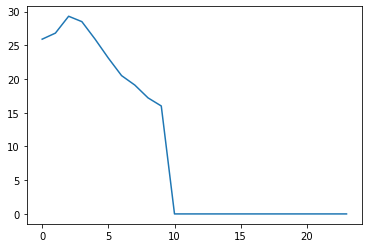

In [406]:
plt.plot(padded_test_seq)

In [407]:
len(padded_test_seq)

24

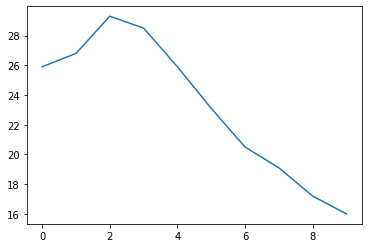

In [408]:
plt.plot(test_np[86+72:86+72+24])

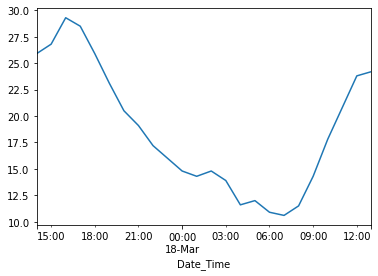

In [409]:
d_r['T'].iloc[6+86+72:6+86+72+24].plot()

In [410]:
len(test_np[86+72:86+72+24])

10

In [ ]:
np.sum(np.abs(padded_test_seq - d_r['T'].iloc[6+86+72:6+86+72+24].to_numpy())) # constant 0

215.3

In [ ]:
np.sum(np.abs(padded_test_seq - d_r['T'].iloc[6+86+72:6+86+72+24].to_numpy())) # edge

53.89999999999999

In [ ]:
np.sum(np.abs(padded_test_seq - d_r['T'].iloc[6+86+72:6+86+72+24].to_numpy())) #symmetric 

127.5

In [ ]:
np.sum(np.abs(padded_test_seq - d_r['T'].iloc[6+86+72:6+86+72+24].to_numpy())) # reflect

136.79999999999998

In [ ]:
## Data processing

train_x_co = []
train_y_co = []
train_x_t = []
train_y_t = []

history = 72
horizon = 24

for i in range(len(train_data)-history):
    train_x_co_t = train_data['CO(GT)'].iloc[i:i+72].to_numpy()
    train_x_t_t = train_data['T'].iloc[i:i+72].to_numpy()
    train_y_co_t = train_data['CO(GT)'].iloc[i+72:i+72+24].to_numpy()
    if len(train_y_co_t) < 24 :
        print('[INFO] LENGTH IS LESS THAN 24')
        train_y_co_t = np.pad(train_y_co_t,(0,24-len(train_y_co_t)),'edge')
    train_y_t_t = train_data['T'].iloc[i+72:i+72+24].to_numpy()
    if len(train_y_t_t) < 24:
        train_y_t_t = np.pad(train_y_t_t,(0,24-len(train_y_t_t)),'edge')
        
    train_x_co.append(train_x_co_t)
    train_x_t.append(train_x_t_t)
    train_y_co.append(train_y_co_t)
    train_y_t.append(train_y_t_t)
    
    

In [412]:
len(train_x_co)

96

In [413]:
len(train_y_co)

96

In [414]:
train_y_co[-5:]

[array([7.6, 6.7, 5.7, 2.8, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6,
        2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6]),
 array([6.7, 5.7, 2.8, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6,
        2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6]),
 array([5.7, 2.8, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6,
        2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6]),
 array([2.8, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6,
        2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6]),
 array([2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6,
        2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6])]

generated numpy format of data but now using keras timeseries generators

In [121]:
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, InputLayer, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

seq_size = 72 # Number of time steps to look back 

batch_size = 1
train_generator = TimeseriesGenerator(train_data['CO(GT)'], train_data['CO(GT)'], length=seq_size, batch_size=batch_size)

In [ ]:
print("Total number of samples in the original training data = ", len(train_data)) # 95
print("Total number of samples in the generated data = ", len(train_generator))

Total number of samples in the original training data =  168
Total number of samples in the generated data =  96


In [476]:

################################################
#Input dimensions are... (N x seq_size)
print('Build feed forward NN model...')
# create and fit dense model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(seq_size,1)))
# model.add(tf.keras.layers.Embedding(2, 64, input_length=72))
# model.add(Bidirectional(LSTM(32,return_sequences=True,kernel_regularizer='l2'))) #12
model.add(tf.keras.layers.Conv1D(64, 11, activation='relu',padding='same',kernel_regularizer='l1_l2'))
model.add(tf.keras.layers.Conv1D(64, 11, activation='relu',padding='same',kernel_regularizer='l1_l2'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(32, 3, activation='relu',padding='same'))
model.add(tf.keras.layers.Conv1D(32, 3, activation='relu',padding='same'))
model.add(tf.keras.layers.BatchNormalization())
# model.add(Bidirectional(LSTM(32, return_sequences=True)) ) #8
model.add(tf.keras.layers.Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(24,activation='relu'))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['acc','mape'])
print(model.summary()) 

######################################################


Build feed forward NN model...
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 72, 64)            768       
                                                                 
 conv1d_31 (Conv1D)          (None, 72, 64)            45120     
                                                                 
 batch_normalization_13 (Bat  (None, 72, 64)           256       
 chNormalization)                                                
                                                                 
 conv1d_32 (Conv1D)          (None, 72, 32)            6176      
                                                                 
 conv1d_33 (Conv1D)          (None, 72, 32)            3104      
                                                                 
 batch_normalization_14 (Bat  (None, 72, 32)           128       
 chNormalization)     

In [86]:
for i in train_y_co:
    assert len(i) == 24

In [416]:
train_x_co = np.array(train_x_co)


In [417]:
train_x_co.shape

(96, 72)

In [418]:
train_y_co = np.array(train_y_co)
train_y_co.shape

(96, 24)

In [419]:
train_x_co.reshape(-1,72,1).shape

(96, 72, 1)

In [420]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30,restore_best_weights = True)

In [477]:
model.fit(x=train_x_co,y=train_y_co, verbose=2, epochs=500,callbacks=[callback])

Epoch 1/500
3/3 - 1s - loss: 17.5698 - acc: 0.0312 - mape: 79.4385 - 1s/epoch - 412ms/step
Epoch 2/500
3/3 - 0s - loss: 15.8351 - acc: 0.0208 - mape: 73.1096 - 31ms/epoch - 10ms/step
Epoch 3/500
3/3 - 0s - loss: 14.3435 - acc: 0.1250 - mape: 56.6202 - 30ms/epoch - 10ms/step
Epoch 4/500
3/3 - 0s - loss: 13.0646 - acc: 0.1354 - mape: 47.7031 - 30ms/epoch - 10ms/step
Epoch 5/500
3/3 - 0s - loss: 11.9032 - acc: 0.1667 - mape: 43.6351 - 33ms/epoch - 11ms/step
Epoch 6/500
3/3 - 0s - loss: 10.8117 - acc: 0.2812 - mape: 37.3120 - 29ms/epoch - 10ms/step
Epoch 7/500
3/3 - 0s - loss: 9.7846 - acc: 0.2604 - mape: 32.6894 - 34ms/epoch - 11ms/step
Epoch 8/500
3/3 - 0s - loss: 8.8421 - acc: 0.2917 - mape: 28.7158 - 37ms/epoch - 12ms/step
Epoch 9/500
3/3 - 0s - loss: 7.9711 - acc: 0.3646 - mape: 26.8630 - 30ms/epoch - 10ms/step
Epoch 10/500
3/3 - 0s - loss: 7.1676 - acc: 0.3958 - mape: 24.4490 - 29ms/epoch - 10ms/step
Epoch 11/500
3/3 - 0s - loss: 6.4127 - acc: 0.4479 - mape: 23.2349 - 31ms/epoch - 10

In [ ]:
del model

In [478]:
preds = model.predict(train_x_co)

In [479]:
preds[:5]

array([[2.6261103, 2.5228548, 2.3772092, 2.3567119, 2.2336268, 1.0296775,
        0.9865369, 1.0405614, 1.365569 , 1.458264 , 2.046297 , 2.7795   ,
        2.94689  , 1.9357868, 1.6993185, 1.9753442, 3.0666718, 2.8489506,
        2.7832134, 4.762689 , 5.7933674, 3.3309512, 2.0982542, 2.2343829],
       [2.5196657, 2.0948312, 2.367355 , 2.33253  , 1.2055206, 1.0248557,
        0.7465921, 1.3925533, 1.701695 , 2.1237228, 2.7178798, 3.0078135,
        1.962702 , 1.6829063, 1.8838108, 2.9283533, 2.8882744, 2.668889 ,
        4.6529775, 5.8423576, 3.2486055, 1.8430072, 2.0882597, 2.1212847],
       [2.233568 , 1.9766598, 2.2556179, 1.5229789, 0.9927546, 1.1296853,
        1.3320417, 1.7582486, 2.3809674, 2.870136 , 2.7435565, 2.1841993,
        1.8332123, 2.1869755, 2.9380136, 2.8822944, 2.8993149, 4.904129 ,
        5.7391157, 3.7168803, 2.1223013, 1.762909 , 1.8994577, 1.931157 ],
       [1.9555416, 2.134345 , 1.2529683, 1.0521457, 0.9851323, 1.7016798,
        2.0117607, 2.2854857, 2.622

In [424]:
train_y_co[:5]

array([[2.9, 2.8, 2.5, 2.4, 2.4, 1.2, 1. , 0.9, 1.4, 1.6, 2.2, 2.8, 2.8,
        2. , 1.8, 1.9, 3. , 2.9, 2.5, 4.6, 5.9, 3.4, 2.1, 2.2],
       [2.8, 2.5, 2.4, 2.4, 1.2, 1. , 0.9, 1.4, 1.6, 2.2, 2.8, 2.8, 2. ,
        1.8, 1.9, 3. , 2.9, 2.5, 4.6, 5.9, 3.4, 2.1, 2.2, 1.8],
       [2.5, 2.4, 2.4, 1.2, 1. , 0.9, 1.4, 1.6, 2.2, 2.8, 2.8, 2. , 1.8,
        1.9, 3. , 2.9, 2.5, 4.6, 5.9, 3.4, 2.1, 2.2, 1.8, 1.8],
       [2.4, 2.4, 1.2, 1. , 0.9, 1.4, 1.6, 2.2, 2.8, 2.8, 2. , 1.8, 1.9,
        3. , 2.9, 2.5, 4.6, 5.9, 3.4, 2.1, 2.2, 1.8, 1.8, 1.8],
       [2.4, 1.2, 1. , 0.9, 1.4, 1.6, 2.2, 2.8, 2.8, 2. , 1.8, 1.9, 3. ,
        2.9, 2.5, 4.6, 5.9, 3.4, 2.1, 2.2, 1.8, 1.8, 1.8, 1.1]])

In [480]:
next_pred = model.predict(train_data['CO(GT)'].iloc[-72:].to_numpy().reshape(1,-1))

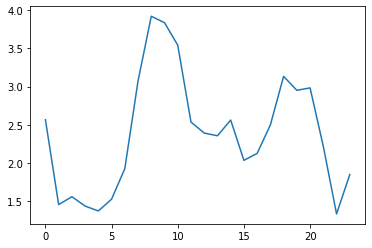

In [481]:
plt.plot(next_pred.squeeze())

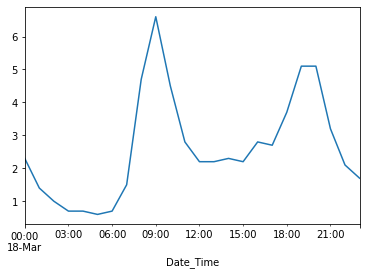

In [427]:
test_data['CO(GT)'].iloc[:24].plot()

In [482]:
print(f"MAPE : {mean_absolute_percentage_error(next_pred.squeeze(),test_data['CO(GT)'].iloc[:24])}")

MAPE : 0.33315323186448753


In [ ]:
d_r.iloc[5*24+6]

CO(GT)              2.1000
PT08.S1(CO)      1304.0000
NMHC(GT)          155.0000
C6H6(GT)           11.1000
PT08.S2(NMHC)    1019.0000
NOx(GT)           127.0000
PT08.S3(NOx)      852.0000
NO2(GT)           103.0000
PT08.S4(NO2)     1731.0000
PT08.S5(O3)      1272.0000
T                  14.1000
RH                 65.7000
AH                  1.0494
Name: 2004-03-16 00:00:00, dtype: float64

In [446]:
test_set = []
for i in range(5,11):
    test_set.append(d_r['CO(GT)'].iloc[i*24+6:(i+3)*24+6].to_numpy())
    

In [447]:
test_set[0]

array([2.1, 1.2, 0.8, 0.7, 0.7, 0.6, 0.9, 1.3, 3.4, 3.7, 5.3, 4.1, 3.3,
       4. , 3.8, 2.8, 2.9, 2.9, 3.4, 3.9, 3.2, 5.1, 2.6, 1.7, 1.7, 1.2,
       0.9, 0.7, 0.7, 0.5, 0.5, 1.6, 4.1, 6.6, 4.3, 2.9, 2.5, 2.8, 2.6,
       2. , 2.9, 2.5, 5. , 7.6, 6.7, 5.7, 2.8, 2.6, 2.3, 1.4, 1. , 0.7,
       0.7, 0.6, 0.7, 1.5, 4.7, 6.6, 4.5, 2.8, 2.2, 2.2, 2.3, 2.2, 2.8,
       2.7, 3.7, 5.1, 5.1, 3.2, 2.1, 1.7])

In [483]:
test_set_preds = model.predict(np.array(test_set))

In [484]:
for i,pred in enumerate(test_set_preds):
    print(f"{i}) MAPE : {mean_absolute_percentage_error(pred,d_r['CO(GT)'].iloc[(8+i)*24+6:(9+i)*24+6].to_numpy())} ")

0) MAPE : 0.26791434412350545 
1) MAPE : 0.28978991299734913 
2) MAPE : 0.33951757952024675 
3) MAPE : 0.4236968512062704 
4) MAPE : 0.2786359763744636 
5) MAPE : 0.3807077287202973 


In [ ]:
i = 0
d_r['CO(GT)'].iloc[(8+i)*24+6:(9+i)*24+6]

In [485]:

t = list(test_set_preds[0])
for i in range(1,len(test_set_preds)):
    t= t+list(test_set_preds[i])

In [486]:
t_backup = t

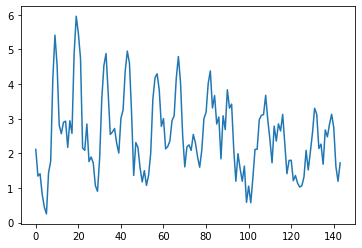

In [487]:
plt.plot(t)

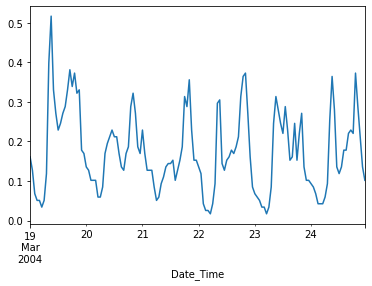

In [190]:
test_data['CO(GT)'].iloc[24:].plot()

In [488]:
t = list(next_pred.squeeze()) + t
print(len(t))

168


In [489]:
print(f"MAPE : {mean_absolute_percentage_error(t,test_data['CO(GT)'])}")

MAPE : 0.3304879464009457


In [390]:
print(f"MAPE : {mean_absolute_percentage_error(scaler_co.inverse_transform(np.array(t).reshape(-1,1)),scaler_co.inverse_transform(test_data['CO(GT)'].to_numpy().reshape(-1,1)))}")

MAPE : 0.3452536606279652


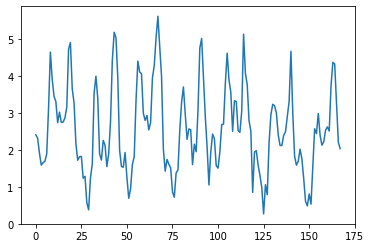

In [394]:
plt.plot(scaler_co.inverse_transform(np.array(t).reshape(-1,1)))

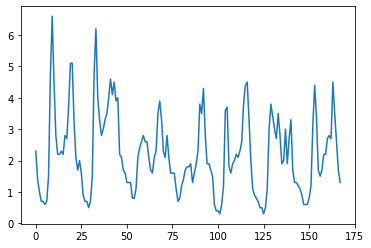

In [393]:
plt.plot(scaler_co.inverse_transform(test_data['CO(GT)'].to_numpy().reshape(-1,1)))

In [490]:
model.save('1D_CNN_MAPE_0_3304.h5')

In [491]:
test_model = keras.models.load_model('1D_CNN_MAPE_0_3304.h5') # working

```python 
import pickle

file_name = 'DNN_MAPE_0.3912.pkl'
pickle.dump(model,open(file_name,'w'))
```

In [397]:
import pickle

file_name = '1D_CNN_MAPE_0_3452_scaler_co.pkl'
pickle.dump(scaler_co,open(file_name,'wb'))

In [712]:
m_t_1 = tf.keras.Sequential()
m_t_1.add(tf.keras.layers.Embedding(36, 64, input_length=72))
m_t_1.add(Bidirectional(LSTM(32,return_sequences=True)))
m_t_1.add(Bidirectional(LSTM(32, return_sequences=True)) )
m_t_1.add(tf.keras.layers.BatchNormalization())

m_t_2 = tf.keras.Sequential()
m_t_2.add(tf.keras.layers.Conv1D(64, 11, activation='relu',padding='same'))
m_t_2.add(tf.keras.layers.Conv1D(64, 11, activation='relu',padding='same'))
m_t_2.add(tf.keras.layers.BatchNormalization())
m_t_2.add(tf.keras.layers.Conv1D(32, 7, activation='relu',padding='same'))
m_t_2.add(tf.keras.layers.Conv1D(32, 7, activation='relu',padding='same'))
m_t_2.add(tf.keras.layers.BatchNormalization())
m_t_2.add(tf.keras.layers.Conv1D(16, 5, activation='relu',padding='same'))
m_t_2.add(tf.keras.layers.Conv1D(16, 5, activation='relu',padding='same'))
m_t_2.add(tf.keras.layers.BatchNormalization())

input_rnn = tf.keras.layers.Input(shape=(72,1))
input_cnn = tf.keras.layers.Input(shape=(72,1))

input_encoded_rnn = m_t_1(input_rnn)
input_encoded_cnn = m_t_2(input_cnn)

# model_t_1 = tf.keras.layers.concatenate([input_encoded_rnn,input_encoded_cnn])
model_t_1 = tf.keras.layers.Dot(axes=(1,1))([input_encoded_rnn,input_encoded_cnn])
model_t_1 = (tf.keras.layers.Flatten())(model_t_1)
model_t_1 = (Dense(128,activation='relu'))(model_t_1)
model_t_1 = (Dense(128,activation='relu'))(model_t_1)
model_t_1 = (Dense(24,activation='relu'))(model_t_1)

model_t_2 = tf.keras.Model([input_rnn,input_cnn],model_t_1)
model_t_2.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['acc','mape'])
print(model_t_2.summary()) 

######################################################

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_80 (InputLayer)          [(None, 72, 1)]      0           []                               
                                                                                                  
 input_81 (InputLayer)          [(None, 72, 1)]      0           []                               
                                                                                                  
 sequential_77 (Sequential)     (None, 72, 64)       52224       ['input_80[0][0]']               
                                                                                                  
 sequential_78 (Sequential)     (None, 72, 16)       71776       ['input_81[0][0]']               
                                                                                            

In [682]:
tf.config.run_functions_eagerly(True)

In [713]:
model_t_2.fit(x=[train_x_t,train_x_t],y=train_y_t, verbose=2, epochs=2000,callbacks=[callback])

Epoch 1/2000
3/3 - 1s - loss: 14.2313 - acc: 0.0521 - mape: 78.8040 - 753ms/epoch - 251ms/step
Epoch 2/2000
3/3 - 0s - loss: 10.2005 - acc: 0.0521 - mape: 57.7801 - 415ms/epoch - 138ms/step
Epoch 3/2000
3/3 - 0s - loss: 7.9353 - acc: 0.0312 - mape: 44.6059 - 391ms/epoch - 130ms/step
Epoch 4/2000
3/3 - 0s - loss: 7.3304 - acc: 0.0729 - mape: 42.3321 - 405ms/epoch - 135ms/step
Epoch 5/2000
3/3 - 0s - loss: 6.6097 - acc: 0.0417 - mape: 37.9781 - 412ms/epoch - 137ms/step
Epoch 6/2000
3/3 - 0s - loss: 5.9291 - acc: 0.0938 - mape: 34.4547 - 409ms/epoch - 136ms/step
Epoch 7/2000
3/3 - 0s - loss: 5.1990 - acc: 0.1042 - mape: 29.3270 - 432ms/epoch - 144ms/step
Epoch 8/2000
3/3 - 0s - loss: 4.8483 - acc: 0.1146 - mape: 28.6212 - 409ms/epoch - 136ms/step
Epoch 9/2000
3/3 - 0s - loss: 4.6490 - acc: 0.1354 - mape: 25.7973 - 424ms/epoch - 141ms/step
Epoch 10/2000
3/3 - 0s - loss: 4.2936 - acc: 0.1458 - mape: 25.6921 - 424ms/epoch - 141ms/step
Epoch 11/2000
3/3 - 0s - loss: 3.9599 - acc: 0.2188 - map

In [665]:
################################################
#Input dimensions are... (N x seq_size)
print('Build feed forward NN model...')
# create and fit dense model
model_t = tf.keras.Sequential()
model_t.add(tf.keras.layers.Input(shape=(seq_size,)))
model_t.add(tf.keras.layers.Embedding(36, 64, input_length=72))
model_t.add(Bidirectional(LSTM(64,return_sequences=True))) #12
# model_t.add(tf.keras.layers.Conv1D(64, 11, activation='relu',padding='same'))
# model_t.add(tf.keras.layers.Conv1D(64, 11, activation='relu',padding='same'))
# model_t.add(tf.keras.layers.BatchNormalization())
# model_t.add(tf.keras.layers.Conv1D(32, 5, activation='relu',padding='same'))
# model_t.add(tf.keras.layers.Conv1D(32, 5, activation='relu',padding='same'))
# model_t.add(tf.keras.layers.BatchNormalization())
# model_t.add(tf.keras.layers.Conv1D(16, 3, activation='relu',padding='same'))
# model_t.add(tf.keras.layers.Conv1D(16, 3, activation='relu',padding='same'))
# model_t.add(tf.keras.layers.BatchNormalization())
model_t.add(Bidirectional(LSTM(64, return_sequences=True)) ) #8
model_t.add(tf.keras.layers.BatchNormalization())
model_t.add(tf.keras.layers.Flatten())
model_t.add(Dense(128,activation='relu',kernel_regularizer='l1_l2'))
model_t.add(Dense(128,activation='relu',kernel_regularizer='l1_l2'))
model_t.add(Dense(24,activation='relu',kernel_regularizer='l1_l2'))
model_t.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['acc','mape'])
print(model_t.summary()) 

######################################################

Build feed forward NN model...
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 72, 64)            2304      
                                                                 
 bidirectional_42 (Bidirecti  (None, 72, 128)          66048     
 onal)                                                           
                                                                 
 bidirectional_43 (Bidirecti  (None, 72, 128)          98816     
 onal)                                                           
                                                                 
 batch_normalization_43 (Bat  (None, 72, 128)          512       
 chNormalization)                                                
                                                                 
 flatten_39 (Flatten)        (None, 9216)              0         
                      

In [493]:
train_x_t = np.array(train_x_t)
train_x_t.shape

(96, 72)

In [494]:
train_y_t = np.array(train_y_t)
train_y_t.shape

(96, 24)

In [527]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50,restore_best_weights = True)

In [666]:
model_t.fit(x=train_x_t,y=train_y_t, verbose=2, epochs=2000,callbacks=[callback])

Epoch 1/2000
3/3 - 6s - loss: 175.4801 - acc: 0.0208 - mape: 99.4248 - 6s/epoch - 2s/step
Epoch 2/2000
3/3 - 0s - loss: 142.9595 - acc: 0.0312 - mape: 98.6090 - 258ms/epoch - 86ms/step
Epoch 3/2000
3/3 - 0s - loss: 115.0865 - acc: 0.0312 - mape: 95.7021 - 260ms/epoch - 87ms/step
Epoch 4/2000
3/3 - 0s - loss: 89.9828 - acc: 0.0833 - mape: 77.6809 - 261ms/epoch - 87ms/step
Epoch 5/2000
3/3 - 0s - loss: 68.7381 - acc: 0.0833 - mape: 54.1100 - 261ms/epoch - 87ms/step
Epoch 6/2000
3/3 - 0s - loss: 54.5124 - acc: 0.0625 - mape: 46.5113 - 256ms/epoch - 85ms/step
Epoch 7/2000
3/3 - 0s - loss: 44.3241 - acc: 0.0312 - mape: 42.4570 - 254ms/epoch - 85ms/step
Epoch 8/2000
3/3 - 0s - loss: 38.0308 - acc: 0.0417 - mape: 43.3552 - 261ms/epoch - 87ms/step
Epoch 9/2000
3/3 - 0s - loss: 35.2924 - acc: 0.0625 - mape: 41.4848 - 248ms/epoch - 83ms/step
Epoch 10/2000
3/3 - 0s - loss: 34.1551 - acc: 0.0312 - mape: 42.6764 - 254ms/epoch - 85ms/step
Epoch 11/2000
3/3 - 0s - loss: 31.7279 - acc: 0.0417 - mape: 

In [714]:
preds = model_t_2.predict([train_x_t,train_x_t])
preds[:5]

array([[6.3272305, 6.7567787, 5.630401 , 5.336433 , 5.7525635, 5.5874457,
        4.8604193, 4.428893 , 0.       , 4.975553 , 6.0685606, 7.19616  ,
        7.9114094, 8.934135 , 8.971631 , 9.146347 , 9.5726385, 9.437356 ,
        8.938354 , 7.3300934, 7.8641233, 7.102574 , 7.0699267, 6.459242 ],
       [6.207152 , 6.0562596, 5.5872474, 5.443962 , 5.4320993, 5.3646245,
        5.124985 , 5.070861 , 0.       , 5.839041 , 6.84923  , 7.8837886,
        8.559921 , 9.0388365, 8.965008 , 8.6205015, 8.8865   , 8.722362 ,
        8.329388 , 7.239157 , 7.301295 , 6.872682 , 6.6466203, 6.330051 ],
       [5.9889793, 5.8524985, 5.6520343, 5.274489 , 5.249319 , 5.124202 ,
        5.2462554, 5.6369247, 0.       , 6.690739 , 7.6149616, 8.466606 ,
        9.109151 , 9.086324 , 9.078885 , 8.383471 , 8.445141 , 8.198883 ,
        8.031173 , 7.0999627, 7.0428715, 6.687433 , 6.475526 , 6.2413244],
       [5.648547 , 5.5495343, 5.4083853, 5.0500817, 5.2021375, 5.3616934,
        5.7502885, 6.2713156, 0.   

In [552]:
train_y_t[:5]

array([[13.9, 14.6, 12.5, 11.6, 12.1, 11.5, 11.6, 10.4, 11.6, 12.4, 14.5,
        16.9, 19.3, 21.2, 21.4, 21.9, 22.2, 21.3, 19.7, 18.4, 17.6, 16.7,
        16.3, 14.7],
       [14.6, 12.5, 11.6, 12.1, 11.5, 11.6, 10.4, 11.6, 12.4, 14.5, 16.9,
        19.3, 21.2, 21.4, 21.9, 22.2, 21.3, 19.7, 18.4, 17.6, 16.7, 16.3,
        14.7, 14.8],
       [12.5, 11.6, 12.1, 11.5, 11.6, 10.4, 11.6, 12.4, 14.5, 16.9, 19.3,
        21.2, 21.4, 21.9, 22.2, 21.3, 19.7, 18.4, 17.6, 16.7, 16.3, 14.7,
        14.8, 14. ],
       [11.6, 12.1, 11.5, 11.6, 10.4, 11.6, 12.4, 14.5, 16.9, 19.3, 21.2,
        21.4, 21.9, 22.2, 21.3, 19.7, 18.4, 17.6, 16.7, 16.3, 14.7, 14.8,
        14. , 13.4],
       [12.1, 11.5, 11.6, 10.4, 11.6, 12.4, 14.5, 16.9, 19.3, 21.2, 21.4,
        21.9, 22.2, 21.3, 19.7, 18.4, 17.6, 16.7, 16.3, 14.7, 14.8, 14. ,
        13.4, 12.6]])

In [715]:
next_pred = model_t_2.predict([train_data['T'].iloc[-72:].to_numpy().reshape(1,-1),train_data['T'].iloc[-72:].to_numpy().reshape(1,-1)])

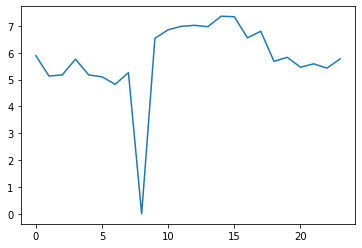

In [716]:
plt.plot(next_pred.squeeze())

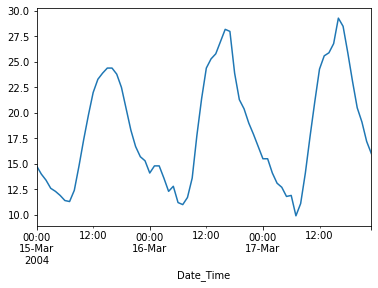

In [501]:
train_data['T'].iloc[-72:].plot()

In [717]:
print(f"MAPE : {mean_absolute_percentage_error(next_pred.squeeze(),test_data['T'].iloc[:24])}")

MAPE : 2157974821448364.8


In [704]:
test_set = []
for i in range(5,11):
    test_set.append(d_r['T'].iloc[i*24+6:(i+3)*24+6].to_numpy())

In [705]:
test_set_preds = model_t_2.predict([np.array(test_set),np.array(test_set)])

In [706]:
for i,pred in enumerate(test_set_preds):
    print(f"{i}) MAPE : {mean_absolute_percentage_error(pred,d_r['T'].iloc[(8+i)*24+6:(9+i)*24+6].to_numpy())} ")

0) MAPE : 0.18795630423757817 
1) MAPE : 0.6551519514109244 
2) MAPE : 0.8218435657746849 
3) MAPE : 0.5913349726590198 
4) MAPE : 0.26810529208872175 
5) MAPE : 0.19274498100101714 


In [707]:
t = list(test_set_preds[0])
for i in range(1,len(test_set_preds)):
    t= t+list(test_set_preds[i])

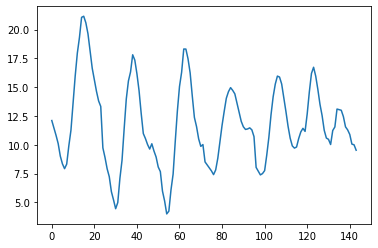

In [708]:
plt.plot(t)

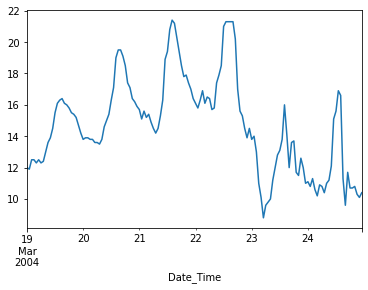

In [546]:
test_data['T'].iloc[24:].plot()

In [709]:
t = list(next_pred.squeeze()) + t
print(len(t))

168


In [710]:
print(f"MAPE : {mean_absolute_percentage_error(t,test_data['T'])}")

MAPE : 0.4283967916683465


In [600]:
model_t.save('1D_CNN_MAPE_0_1721_T.h5')

In [587]:
test_model_t = tf.keras.models.load_model('1D_CNN_MAPE_0_1751_T.h5')

```python>>> import calendar
>>> import datetime as dt
>>> import math
>>> from river import compose
>>> from river import datasets
>>> from river import linear_model
>>> from river import metrics
>>> from river import optim
>>> from river import preprocessing
>>> from river import time_series

>>> def get_month_distances(x):
...     return {
...         calendar.month_name[month]: math.exp(-(x['month'].month - month) ** 2)
...         for month in range(1, 13)
...     }

>>> def get_ordinal_date(x):
...     return {'ordinal_date': x['month'].toordinal()}

>>> extract_features = compose.TransformerUnion(
...     get_ordinal_date,
...     get_month_distances
... )

>>> model = (
...     extract_features |
...     time_series.SNARIMAX(
...         p=0,
...         d=0,
...         q=0,
...         m=12,
...         sp=3,
...         sq=6,
...         regressor=(
...             preprocessing.StandardScaler() |
...             linear_model.LinearRegression(
...                 intercept_init=110,
...                 optimizer=optim.SGD(0.01),
...                 intercept_lr=0.3
...             )
...         )
...     )
... )

>>> metric = metrics.Rolling(metrics.MAE(), 12)

>>> for x, y in datasets.AirlinePassengers():
...     y_pred = model.forecast(horizon=1, xs=[x])
...     model = model.learn_one(x, y)
...     metric = metric.update(y, y_pred[0])

>>> metric
MAE: 11.636563  (rolling 12)

>>> horizon = 12
>>> future = [
...     {'month': dt.date(year=1961, month=m, day=1)}
...     for m in range(1, horizon + 1)
... ]
>>> forecast = model.forecast(horizon=horizon, xs=future)
>>> for x, y_pred in zip(future, forecast):
...     print(x['month'], f'{y_pred:.3f}')
1961-01-01 442.554
1961-02-01 427.305
1961-03-01 471.861
1961-04-01 483.978
1961-05-01 489.995
1961-06-01 544.270
1961-07-01 632.882
1961-08-01 633.229
1961-09-01 531.349
1961-10-01 457.258
1961-11-01 405.978
1961-12-01 439.674
```

In [588]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U tensorflow

     |████████████████████████████████| 207.0 MB 52 kB/s eta 0:00:014
     |████████████████████████████████| 463 kB 592 kB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 846 kB/s eta 0:00:01
     |████████████████████████████████| 13.0 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 97 kB/s eta 0:00:012
     |████████████████████████████████| 1.6 MB 98 kB/s eta 0:00:013
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0


  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0
